# 1. What it is Probability Reliability (Calibration) in the end?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

X, y = make_classification(n_samples=20_000, n_features=10, n_informative=8, n_redundant=1, n_repeated=1, 
                           random_state=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [2]:
models = [
    HistGradientBoostingClassifier(max_depth=5, random_state=1),
    RandomForestClassifier(max_depth=5, random_state=2),
    LogisticRegression(),
]

gb = models[0]
rf = models[1]
lr = models[2]

gb.fit(X_train, y_train);
rf.fit(X_train, y_train);
lr.fit(X_train, y_train);

In [3]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

def compare_models(model_list, X_test, y_test):
    fig, ax = plt.subplots(figsize=(12,6), ncols=2)
    for model in model_list:

        model_name = type(model).__name__

        y_probs = model.predict_proba(X_test)[:,1]

        # ROC
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        auc = roc_auc_score(y_test, y_probs)

        # PR
        prec, rec, _ = precision_recall_curve(y_test, y_probs)
        ap = average_precision_score(y_test, y_probs)

        # plot
        ax[0].plot(fpr, tpr, label=model_name + " (AUC={0:.2f})".format(auc))
        ax[1].plot(rec, prec, label=model_name + " (AP={0:.2f})".format(ap))

    ax[0].legend(); ax[1].legend()
    ax[0].plot([0,1], linestyle='--', color='gray')
    ax[0].set_title("ROC curves"); ax[1].set_title("Precision-Recall curves")

    plt.tight_layout()

    plt.show()

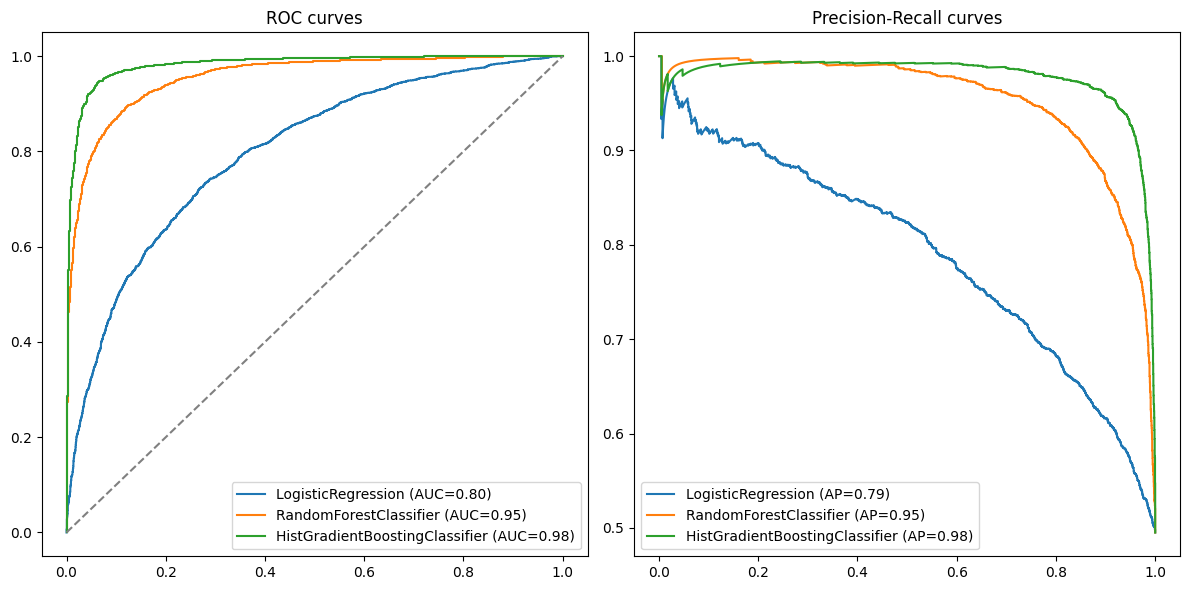

In [4]:
compare_models(model_list=[lr, rf, gb], X_test=X_test, y_test=y_test)

 **1.1 Reliability Diagrams**

In [5]:
y_probs = lr.predict_proba(X_test)[:,1]

In [6]:
predictions = pd.DataFrame({
    'label': y_test,
    'score': y_probs,
})

predictions.head()

,label,score
0,0,0.740110
1,0,0.648457
2,1,0.524043
3,1,0.939656
4,0,0.164257


In [7]:
predictions = predictions.sort_values('score')

predictions['bins'] = pd.cut(predictions['score'], bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])
predictions

,label,score,bins
1273,0,0.008941,"(0.0, 0.2]"
52,0,0.009827,"(0.0, 0.2]"
4586,0,0.011319,"(0.0, 0.2]"
4442,0,0.017242,"(0.0, 0.2]"
5826,0,0.021725,"(0.0, 0.2]"
...,...,...,...
3793,1,0.981494,"(0.8, 1.0]"
1161,1,0.983320,"(0.8, 1.0]"
3822,1,0.984830,"(0.8, 1.0]"
789,1,0.985066,"(0.8, 1.0]"


**Logistic Regression sua linda!**

In [8]:
calibration = predictions.groupby('bins').mean().reset_index(drop=True)
calibration.columns = ['Fraction of positives', 'Average score']
calibration.round(3)

,Fraction of positives,Average score
0,0.138,0.129
1,0.289,0.299
2,0.493,0.498
3,0.713,0.701
4,0.884,0.883


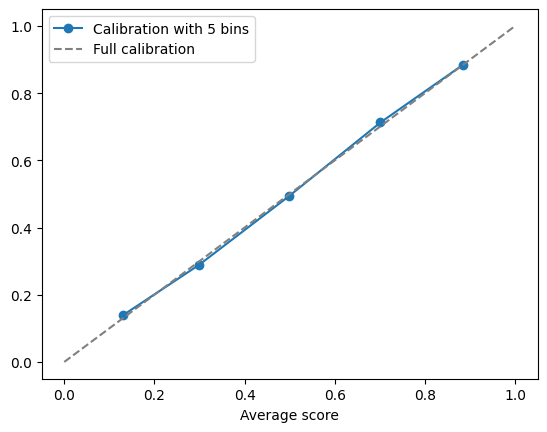

In [9]:
calibration.plot(x='Average score', y='Fraction of positives', label='Calibration with 5 bins', marker='o')
plt.plot([0,1], linestyle='--', color='gray', label='Full calibration')
plt.legend()
plt.show()

**Zooming the calibration curve**

In [10]:
from sklearn.calibration import calibration_curve

def calib_curve_probs(y_true, y_probs, n_bins=10, method='uniform'):
    
    assert method in ['quantile', 'uniform'], "Unrecognized method"
    
    predictions = pd.DataFrame({
        'label': y_true,
        'scores': y_probs,
        })
    
    predictions = predictions.sort_values('scores')
    
    if method == 'quantile':
        quantiles = [predictions['scores'].quantile(q) for q in np.linspace(0, 1, n_bins+1)] 
        predictions['bins'] = pd.cut(predictions['scores'], quantiles)

    else:
        bins=np.linspace(0, 1, n_bins+1) 
        predictions['bins'] = pd.cut(predictions['scores'], bins)
        
    # we can now aggregate: average y=1 per chunk and average score per chunk
    calibration = predictions.groupby('bins').mean().reset_index(drop=True)
    calibration.columns = ['Fraction of positives', 'Average score']
    
    x, y = calibration['Average score'], calibration['Fraction of positives']
    p = predictions.groupby('bins').\
                   apply(lambda x: len(x)).\
                   values
    p = p/len(y_true)
    
    return x, y, p

def plot_calibration_curve(y_true, y_probs, n_bins=10, method='uniform', ax=None, legend=None):
    x, y, p = calib_curve_probs(y_true, y_probs, n_bins=n_bins, method=method)

    p = p/p.max() + p.min()
    
    if ax is None:
        plt.scatter(x, y, s=100*p, marker='o', edgecolors='black')
        plt.plot(x,y, label=legend)
        plt.plot([0,1], linestyle='--', color='gray')
        plt.xlabel("Mean predicted probability")
        plt.ylabel("Fraction of positives")
        if legend is not None:
            plt.legend()
    
    else:
        ax.scatter(x, y, s=100*p, marker='o', edgecolors='black')
        ax.plot(x,y, label=legend)
        ax.plot([0,1], linestyle='--', color='gray')
        ax.set_xlabel("Mean predicted probability")
        ax.set_ylabel("Fraction of positives")
        if legend is not None:
            ax.legend()

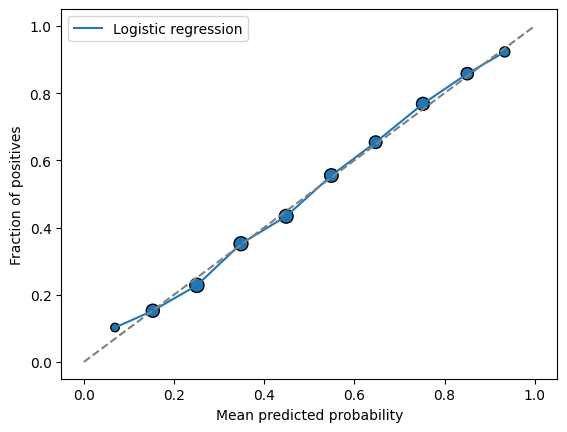

In [11]:
plot_calibration_curve(y_test, y_probs, legend='Logistic regression')

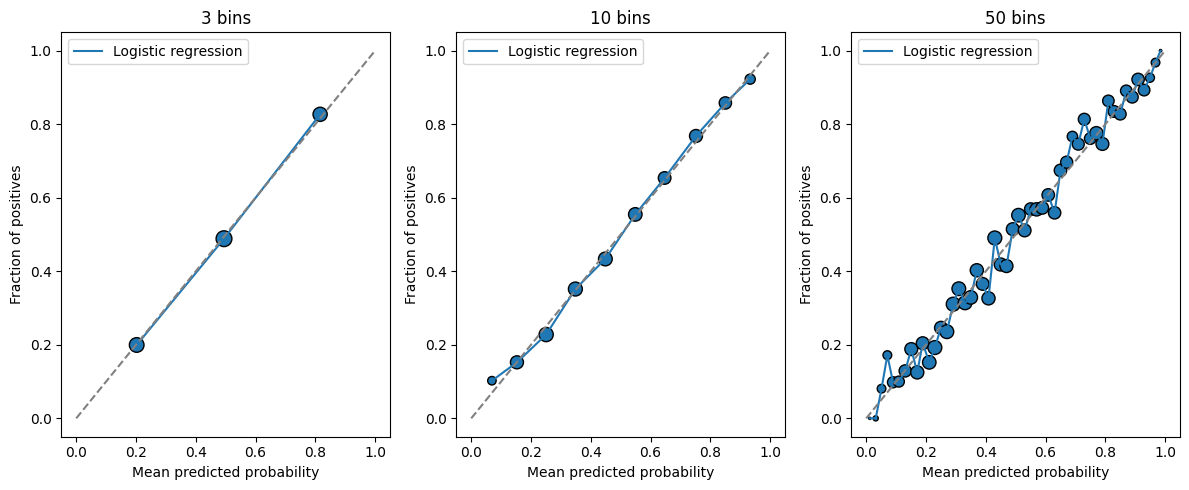

In [12]:
fig, ax = plt.subplots(ncols=3, figsize=(12,5))
for n, axx in zip([3, 10, 50], ax):
    plot_calibration_curve(y_test, y_probs, n_bins=n, ax=axx, legend='Logistic regression')
    axx.set_title(f"{n} bins")
    
plt.tight_layout()
plt.show()

# 2. Which kind of model is more probabilistically reliable?

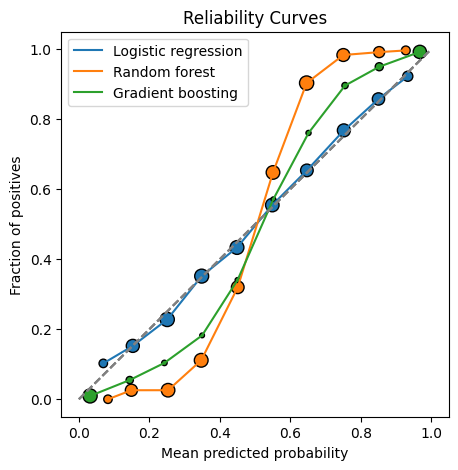

In [13]:
fig, ax = plt.subplots(figsize=(5,5))
for model, name in zip([lr, rf, gb], ["Logistic regression", "Random forest", "Gradient boosting"]):
    plot_calibration_curve(y_test, model.predict_proba(X_test)[:,1], legend=name)
                                       
ax.set_title("Reliability Curves")
plt.show()

## 2.1 Quantifying the Probabilistic Reliability

In [14]:
def ece(y_true, y_probs, n_bins=10, method='uniform'):
    x, y, p = calib_curve_probs(y_true, y_probs, n_bins=n_bins, method=method)
    return np.sum(p*np.abs(x - y))

def mce(y_true, y_probs, n_bins=10, method='uniform'):
    x, y, _ = calib_curve_probs(y_true, y_probs, n_bins=n_bins, method=method)
    return np.max(np.abs(x-y))

In [15]:
print("ECE comparison (the lower, the better): ")
for model in [lr, rf, gb]:

    model_name = type(model).__name__
    
    y_probs = model.predict_proba(X_test)[:,1]
    error = ece(y_test, y_probs)
    
    print(f"{model_name}\t {round(100*error,1 )}%")

print('-----')

print("MCE comparison (the lower, the better): ")
for model in [lr, rf, gb]:

    model_name = type(model).__name__
    
    y_probs = model.predict_proba(X_test)[:,1]
    error = mce(y_test, y_probs)
    
    print(f"{model_name}\t {round(100*error,1 )}%")

ECE comparison (the lower, the better): 
LogisticRegression	 1.1%
RandomForestClassifier	 17.5%
HistGradientBoostingClassifier	 5.7%
-----
MCE comparison (the lower, the better): 
LogisticRegression	 3.3%
RandomForestClassifier	 25.7%
HistGradientBoostingClassifier	 16.7%


# 3. Calibration Methods

# 3.1 Isotonic Regression --> Don´t use Platt Scaling (sigmoidal mapping)

In [16]:
# some point scatter
x0 = 5*np.abs(np.random.randn(200))
x1 = np.sqrt(x0) + np.random.randn(200)

In [17]:
from sklearn.isotonic import IsotonicRegression

iso = IsotonicRegression(increasing=True)
iso.fit(x0,x1)

x0_ = np.linspace(x0.min(), x0.max())
x1_ = iso.predict(x0_)

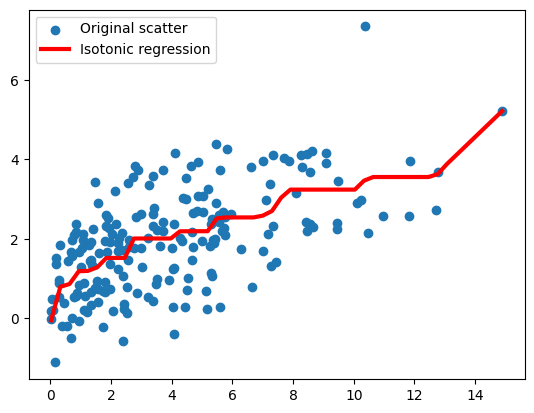

In [18]:
plt.scatter(x0, x1, label='Original scatter')
plt.plot(x0_, x1_, lw=3, color='red', label='Isotonic regression')
plt.legend()
plt.show()

In [19]:
def train_calib_test_split(X, y, train_size=0.5, calib_size=0.25, test_size=0.25, random_state=1):

    from sklearn.model_selection import train_test_split
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size,
                                                                stratify=y, random_state=random_state)
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=calib_size/(train_size+calib_size), 
                                                      stratify=y_train_val, random_state=random_state+12)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [20]:
## Making data - same as before

X, y = make_classification(n_samples=20000, n_features=10, n_informative=8, n_redundant=1, n_repeated=1, 
                           random_state=10)

In [21]:
X_train, X_calib, X_test, y_train, y_calib, y_test = train_calib_test_split(X, y,
                                                                     train_size=0.6,
                                                                     calib_size=0.15,
                                                                     test_size=0.25,
                                                                     random_state=42)

In [22]:
## Train models on TRAINING set

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV

models = [
    HistGradientBoostingClassifier(max_depth=5, random_state=1),
    RandomForestClassifier(max_depth=5, random_state=2),
    LogisticRegression(),
    GaussianNB()
]

for model in models:
    model.fit(X_train, y_train)

In [23]:
# Calibrate models on VALIDATION set
calib_models = []
for model in models:
    calibrator = CalibratedClassifierCV(estimator=model, cv='prefit', method='isotonic')
    calibrator.fit(X_calib, y_calib)
    calib_models.append(calibrator)

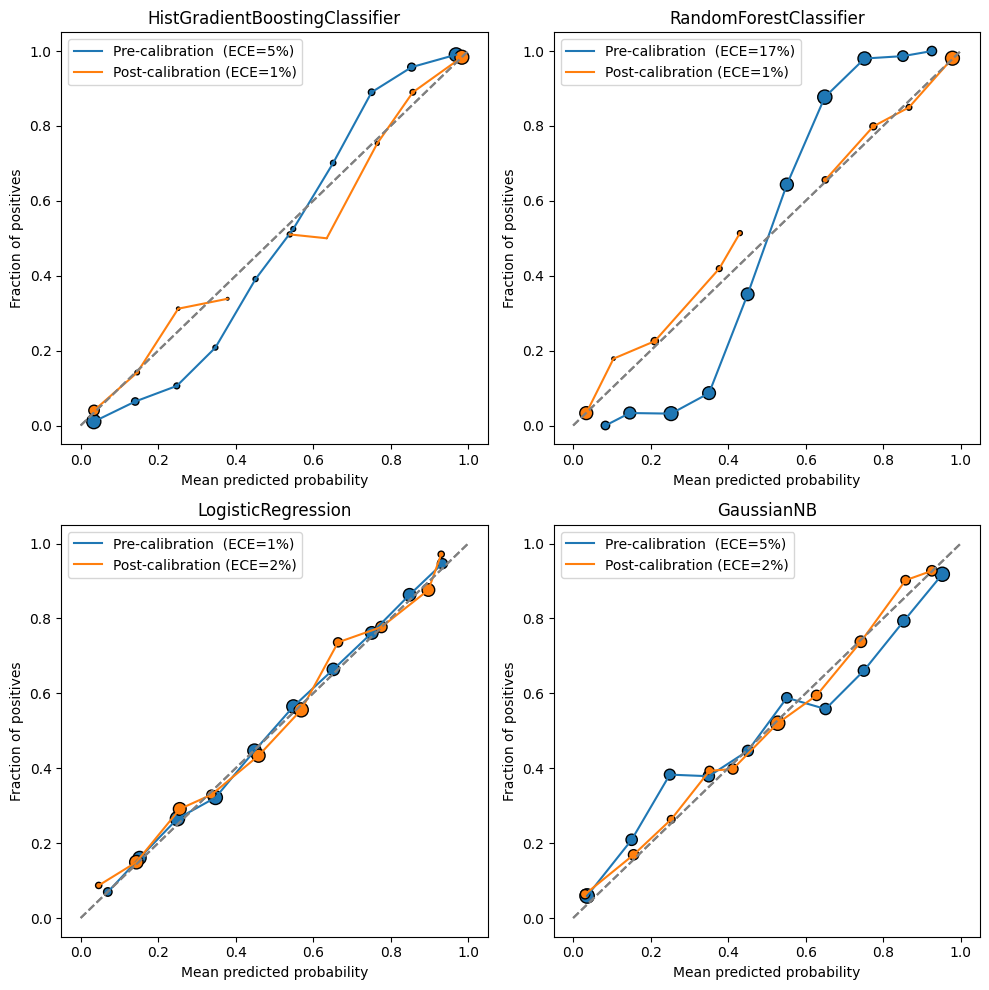

In [24]:
# Assess performance on TEST set
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax = ax.flatten()

for axx, model, calibrator in zip(ax, models, calib_models):
    
    model_name = type(model).__name__

    # base model
    y_probs = model.predict_proba(X_test)[:,1]
    error_base = ece(y_test, y_probs)
    plot_calibration_curve(y_test, y_probs, n_bins=10, ax=axx, 
                           legend=f'Pre-calibration  (ECE={round(100*error_base)}%)')
    
    # calibrated model
    y_probs = calibrator.predict_proba(X_test)[:,1]
    error_calib = ece(y_test, y_probs)
    plot_calibration_curve(y_test, y_probs, n_bins=10, ax=axx, 
                           legend=f'Post-calibration (ECE={round(100*error_calib)}%)')
        
    axx.set_title(model_name) 

plt.tight_layout()
plt.show()

In [52]:
def build_lift_curve(y_actual, y_pred, 
                     ascending=False,
                     return_ideal_curve=True):
    
    """
    Returns the lift curve from actual (0 or 1) data and
    predicted scores.
    
    Also returns what the ideal lift curve for this problem 
    would be, if return_ideal_curve = True
    """
    
    df = pd.DataFrame({'y_actual': y_actual,
                   'prob_default': y_pred})

    # sort from low to high scores
    df = df.sort_values('prob_default', ascending=ascending)
    
    # build cumulative_default
    df['cumulative_default'] = df['y_actual'].cumsum()
    df['lift'] = df['cumulative_default']/df['y_actual'].sum()

    # create index starting from 0 and normalize
    df = df.reset_index(drop=True).reset_index()
    df['index'] = df['index']/(df['index'].iloc[-1])
    df = df.set_index('index')
    
    if return_ideal_curve:
        df_perfect = df.sort_values('y_actual', ascending=ascending)
        df_perfect['cumulative_default'] = df_perfect['y_actual'].cumsum()
        df_perfect['lift'] = df_perfect['cumulative_default']/df_perfect['cumulative_default'].iloc[-1]
        df_perfect = df_perfect.reset_index(drop=True).reset_index()
        df_perfect['index'] = df_perfect['index']/(df_perfect['index'].iloc[-1])
        df_perfect = df_perfect.set_index('index')
        
        return df['lift'], df_perfect['lift']
    
    return df['lift']

def classification_model_report(model, X_calib, y_calib, X_test, y_test):
    
    from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
    from sklearn.calibration import CalibratedClassifierCV
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))  # Change ncols and nrows here
    model_name = type(model).__name__

    plt.suptitle(model_name)
    
    y_probs = model.predict_proba(X_test)[:,1]
    
    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc = roc_auc_score(y_test, y_probs)
    
    # PR
    prec, rec, _ = precision_recall_curve(y_test, y_probs)
    ap = average_precision_score(y_test, y_probs)
    
    # Lift
    lift_curve, ideal_lift_curve = build_lift_curve(y_test, y_probs, return_ideal_curve=True)
    
    ax[0, 0].plot(fpr, tpr, label='ROC base (AUC={0:.2f})'.format(auc)); ax[0, 0].set_title("ROC curve")
    ax[0, 0].legend(); ax[0, 0].set_xlabel("FPR"); ax[0, 0].set_ylabel("TPR")
    
    ax[0, 1].plot(rec, prec, label='PR base (AP={0:.2f})'.format(ap)); ax[0, 1].set_title("Precision-Recall curve")
    ax[0, 1].legend(); ax[0, 1].set_xlabel("Recall"); ax[0, 1].set_ylabel("Precision")
    
    ax[1, 0].plot(lift_curve, label='Lift curve')
    ax[1, 0].plot(ideal_lift_curve, label='Ideal lift curve', linestyle='--')
    ax[1, 0].set_title("Lift curve")
    ax[1, 0].legend(); ax[1, 0].set_xlabel("Proportion of samples"); ax[1, 0].set_ylabel("Lift")
    
    # Calibration
    error = ece(y_test, y_probs) 
    plot_calibration_curve(y_test, y_probs, n_bins=10, ax=ax[1, 1], 
                           legend=f'Pre-calibration  (ECE={round(100*error,1)}%)')


    calibrator = CalibratedClassifierCV(estimator=model, cv='prefit', method='isotonic')
    calibrator.fit(X_calib, y_calib)
    y_probs = calibrator.predict_proba(X_test)[:,1]
    error = ece(y_test, y_probs)
    
    plot_calibration_curve(y_test, y_probs, n_bins=10, ax=ax[1, 1], 
                                        legend=f'Post-calibration  (ECE={round(100*error,1)}%)')

    ax[1, 1].legend(); ax[1, 1].set_title("Reliability curve")
    plt.tight_layout()
    plt.show()
    
    return calibrator


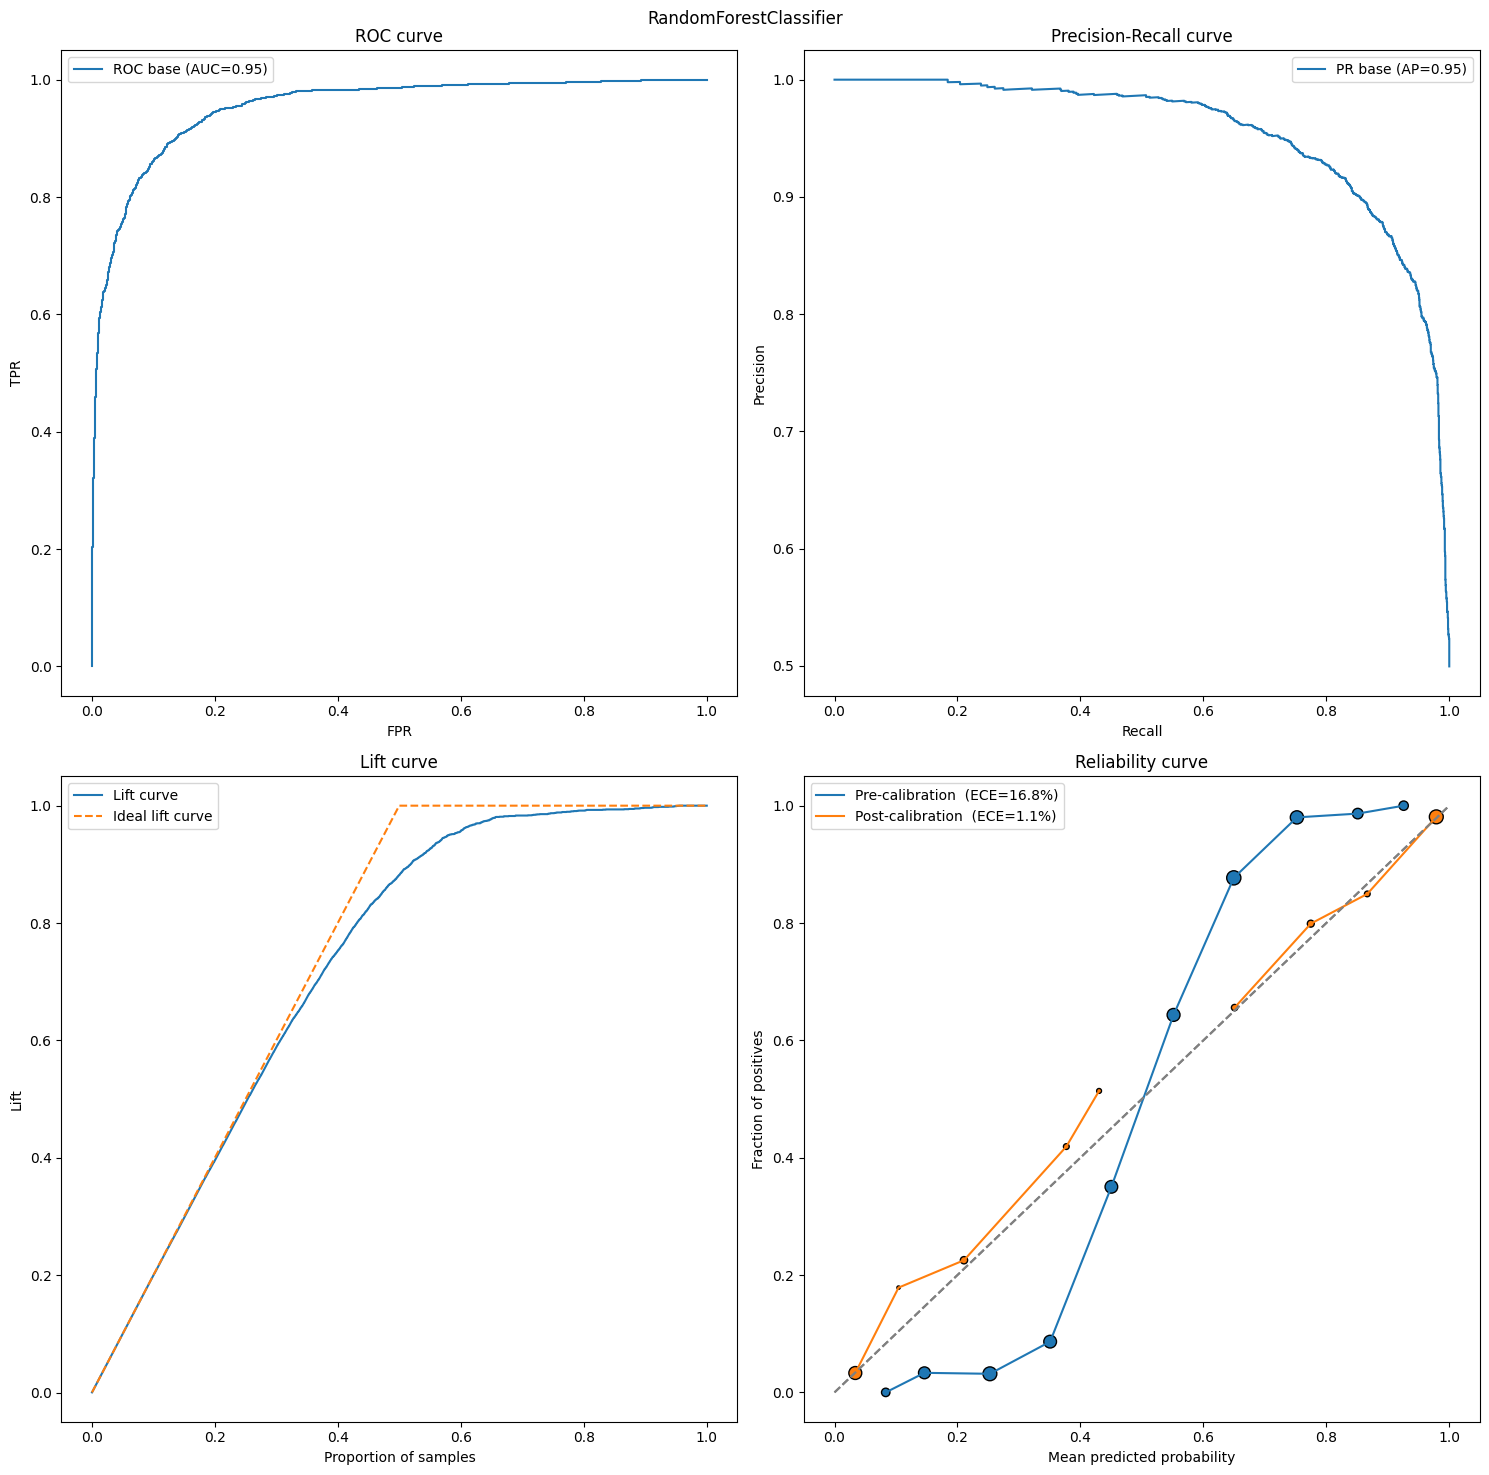

In [53]:
_=classification_model_report(models[1], X_calib, y_calib, X_test, y_test)

# 3.2 Venn-Abbers Predictors

https://cml.rhul.ac.uk/people/ptocca/HomePage/Toccaceli_CP___Venn_Tutorial.pdf

In [27]:
# Straight-forward implementation of IVAP algorithm described in:
# Large-scale probabilistic prediction with and without validity guarantees, Vovk et al.
# https://arxiv.org/pdf/1511.00213.pdf
#
# Paolo Toccaceli
#
# https://github.com/ptocca/VennABERS
#
# 2020-07-09: Fixed bug in p0 calculation

import numpy as np

# Some elementary functions to speak the same language as the paper
# (at some point we'll just replace the occurrence of the calls with the function body itself)
def push(x,stack):
    stack.append(x)

    
def pop(stack):
    return stack.pop()


def top(stack):
    return stack[-1]


def nextToTop(stack):
    return stack[-2]


# perhaps inefficient but clear implementation
def nonleftTurn(a,b,c):   
    d1 = b-a
    d2 = c-b
    return np.cross(d1,d2)<=0


def nonrightTurn(a,b,c):   
    d1 = b-a
    d2 = c-b
    return np.cross(d1,d2)>=0


def slope(a,b):
    ax,ay = a
    bx,by = b
    return (by-ay)/(bx-ax)


def notBelow(t,p1,p2):
    p1x,p1y = p1
    p2x,p2y = p2
    tx,ty = t
    m = (p2y-p1y)/(p2x-p1x)
    b = (p2x*p1y - p1x*p2y)/(p2x-p1x)
    return (ty >= tx*m+b)

kPrime = None

# Because we cannot have negative indices in Python (they have another meaning), I use a dictionary

def algorithm1(P):
    global kPrime
    
    S = []
    P[-1] = np.array((-1,-1))
    push(P[-1],S)
    push(P[0],S)
    for i in range(1,kPrime+1):
        while len(S)>1 and nonleftTurn(nextToTop(S),top(S),P[i]):
            pop(S)
        push(P[i],S)
    return S


def algorithm2(P,S):
    global kPrime
    
    Sprime = S[::-1]     # reverse the stack

    F1 = np.zeros((kPrime+1,))
    for i in range(1,kPrime+1):
        F1[i] = slope(top(Sprime),nextToTop(Sprime))
        P[i-1] = P[i-2]+P[i]-P[i-1]
        if notBelow(P[i-1],top(Sprime),nextToTop(Sprime)):
            continue
        pop(Sprime)
        while len(Sprime)>1 and nonleftTurn(P[i-1],top(Sprime),nextToTop(Sprime)):
            pop(Sprime)
        push(P[i-1],Sprime)
    return F1


def algorithm3(P):
    global kPrime

    S = []
    push(P[kPrime+1],S)
    push(P[kPrime],S)
    for i in range(kPrime-1,0-1,-1):  # k'-1,k'-2,...,0
        while len(S)>1 and nonrightTurn(nextToTop(S),top(S),P[i]):
            pop(S)
        push(P[i],S)
    return S


def algorithm4(P,S):
    global kPrime
    
    Sprime = S[::-1]     # reverse the stack
    
    F0 = np.zeros((kPrime+1,))
    for i in range(kPrime,1-1,-1):   # k',k'-1,...,1
        F0[i] = slope(top(Sprime),nextToTop(Sprime))
        P[i] = P[i-1]+P[i+1]-P[i]
        if notBelow(P[i],top(Sprime),nextToTop(Sprime)):
            continue
        pop(Sprime)
        while len(Sprime)>1 and nonrightTurn(P[i],top(Sprime),nextToTop(Sprime)):
            pop(Sprime)
        push(P[i],Sprime)
    return F0


def prepareData(calibrPoints):
    global kPrime
    
    ptsSorted = sorted(calibrPoints)
    
    xs = np.fromiter((p[0] for p in ptsSorted),float)
    ys = np.fromiter((p[1] for p in ptsSorted),float)
    ptsUnique,ptsIndex,ptsInverse,ptsCounts = np.unique(xs, 
                                                        return_index=True,
                                                        return_counts=True,
                                                        return_inverse=True)
    a = np.zeros(ptsUnique.shape)
    np.add.at(a,ptsInverse,ys)
    # now a contains the sums of ys for each unique value of the objects
    
    w = ptsCounts
    yPrime = a/w
    yCsd = np.cumsum(w*yPrime)   # Might as well do just np.cumsum(a)
    xPrime = np.cumsum(w)
    kPrime = len(xPrime)
    
    return yPrime,yCsd,xPrime,ptsUnique


def computeF(xPrime,yCsd):
    global kPrime
    P = {0:np.array((0,0))}
    P.update({i+1:np.array((k,v)) for i,(k,v) in enumerate(zip(xPrime,yCsd))})
    
    S = algorithm1(P)
    F1 = algorithm2(P,S)
    
    P = {0:np.array((0,0))}
    P.update({i+1:np.array((k,v)) for i,(k,v) in enumerate(zip(xPrime,yCsd))})    
    P[kPrime+1] = P[kPrime] + np.array((1.0,0.0))    # The paper says (1,1)
    
    S = algorithm3(P)
    F0 = algorithm4(P,S)
    
    return F0,F1


def getFVal(F0,F1,ptsUnique,testObjects):
    pos0 = np.searchsorted(ptsUnique,testObjects,side='left')
    pos1 = np.searchsorted(ptsUnique[:-1],testObjects,side='right')+1
    return F0[pos0],F1[pos1]


def ScoresToMultiProbs(calibrPoints,testObjects):
    # sort the points, transform into unique objects, with weights and updated values
    yPrime,yCsd,xPrime,ptsUnique = prepareData(calibrPoints)
    
    # compute the F0 and F1 functions from the CSD
    F0,F1 = computeF(xPrime,yCsd)
    
    # compute the values for the given test objects
    p0,p1 = getFVal(F0,F1,ptsUnique,testObjects)
                    
    return p0,p1

In [28]:
import pandas as pd

def venn_abbers_probabilities(model, X_calib, y_calib, X_test):
    calib_scores = model.predict_proba(X_calib)[:, 1]
    test_scores = model.predict_proba(X_test)[:, 1]
    
    p0, p1 = ScoresToMultiProbs(list(zip(calib_scores, y_calib)), test_scores)
    p = p1 / (1 - p0 + p1)
    
    venn_abbers_df = pd.DataFrame({
        'p': p,
        'proba_interval': abs(p1 - p0)
    })
    
    return venn_abbers_df,p0,p1

In [29]:
venn_abbers_df,p0,p1 = venn_abbers_probabilities(models[1], X_calib, y_calib, X_test)
venn_abbers_df

,p,proba_interval
0,0.017391,0.017699
1,0.006623,0.006667
2,0.977974,0.004425
3,0.621849,0.008475
4,0.872093,0.011765
...,...,...
4995,0.404494,0.011364
4996,0.031702,0.017552
4997,0.788168,0.011583
4998,0.991935,0.008130


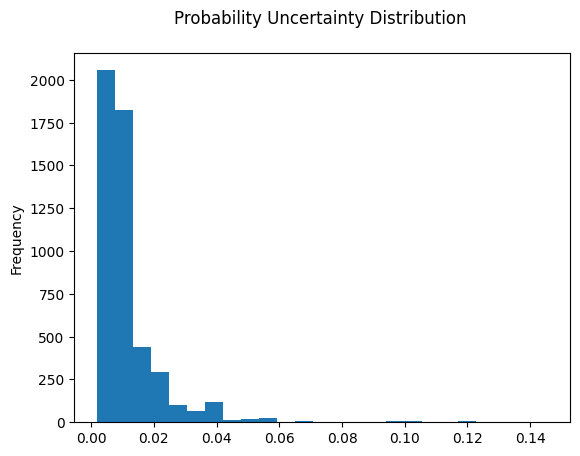

In [55]:
_= venn_abbers_df["proba_interval"].plot(kind="hist",bins=25,title= "Probability Uncertainty Distribution \n")

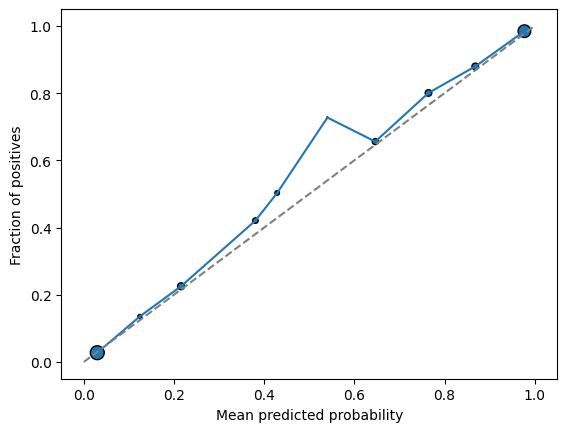

In [61]:
venn_abbers_probas = venn_abbers_df["p"]
plot_calibration_curve(y_test, venn_abbers_probas, n_bins=10, ax=None)

**Calibration via Isotonic regression is known to "overfit"**

- Venn-ABERS predictors lessen this tendency to overfit and inherit the
validity guarantee of Venn predictors.

- Compared with bare Isotonic Regression, the multi-probabilistic output
also provides an indication of the reliability of the probability estimates.

- If the probabilities differ, this can be taken as an indication of the
uncertainty on the probability estimate itself.

- Compared with Platt’s Scaling (fitting a sigmoid as calibrator),
Venn-ABERS predictors do not make any assumption on the shape
(functional form) of the calibrator.

- Works out of the box for unbalanced datasets

In [43]:
f"Venn-Abbers Expected Calibration Error: {ece(y_test,venn_abbers_probas)*100:.2f}%"


'Venn-Abbers Expected Calibration Error: 1.29%'